In [14]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import pairwise_distances
from sklearn.cluster import DBSCAN
from scipy.stats import entropy
from sklearn.manifold import TSNE
import seaborn as sns


In [15]:
def preprocess_data(data):
    # Initialize LabelEncoder for categorical data
    label_encoders = {}
    for column in data.columns:
        if data[column].dtype == object or data[column].dtype.name == 'category':  # Check for categorical data
            le = LabelEncoder()
            data[column] = le.fit_transform(data[column].astype(str))  # Convert categorical data to integers
            label_encoders[column] = le
    
    # Scale numerical data
    scaler = MinMaxScaler()
    numerical_columns = data.select_dtypes(include=['int64']).columns
    data[numerical_columns] = scaler.fit_transform(data[numerical_columns])
    
    return data, label_encoders


In [16]:
def calculate_entropy(data):
    entropy_values = {}
    for column in data.columns:
        if data[column].dtype == np.int32:  # Assuming converted categorical data are integers
            counts = np.bincount(data[column])
            probabilities = counts / len(data[column])
            entropy_values[column] = entropy(probabilities[probabilities > 0])  # Calculate entropy only for positive probabilities
    return entropy_values


In [17]:
def mixed_distance(x, y, numerical_indices, categorical_indices, entropy_values):
    # Numerical distance using Euclidean metric
    numerical_distance = np.linalg.norm(x[numerical_indices] - y[numerical_indices])
    
    # Categorical distance weighted by entropy
    categorical_distance = sum(entropy_values[i] * (x[i] != y[i]) for i in categorical_indices)
    
    return numerical_distance + categorical_distance


In [18]:
def get_distance_matrix(data, entropy_values):
    indices = range(data.shape[1])
    numerical_indices = [i for i in indices if data.dtypes[i] == 'float64']  # Adjusted for scaled numerical data
    categorical_indices = [i for i in indices if data.dtypes[i] == 'int32']  # Adjusted for labeled categorical data

    # Calculate pairwise distances
    distance_matrix = pairwise_distances(data.values, metric=lambda x, y: mixed_distance(x, y, numerical_indices, categorical_indices, entropy_values))
    print(distance_matrix)

    return distance_matrix
 


In [19]:
from sklearn.neighbors import NearestNeighbors
from kneed import KneeLocator
import matplotlib.pyplot as plt


def k_distance_curve(data):
    """
    Plot the k-distance graph for the dataset to find the optimal epsilon (elbow method).
    """
    k = 2 * data.shape[1] - 1
    neigh = NearestNeighbors(n_neighbors=k)
    neigh.fit(data)
    distances, indices = neigh.kneighbors(data)
    
    # Sort distances
    sorted_distances = np.sort(distances[:, k-1], axis=0)
    
    plt.figure(figsize=(10, 5))
    plt.plot(sorted_distances)
    plt.title("K-Distance Graph")
    plt.xlabel("Points sorted by distance")
    plt.ylabel(f"Distance to {k}-th nearest neighbor")
    plt.grid(True)
    plt.show()

    return sorted_distances

def find_knee_point(sorted_distances):
    """
    Detect the knee point using the 'kneed' library to find the optimal epsilon.
    """
    knee_locator = KneeLocator(range(len(sorted_distances)), sorted_distances, curve='convex', direction='increasing')
    knee_point = knee_locator.knee
    
    plt.figure(figsize=(10, 5))
    plt.plot(sorted_distances)
    plt.scatter(knee_point, sorted_distances[knee_point], color='red', label='Knee point')
    plt.title("K-Distance Graph with Knee Point")
    plt.xlabel("Points")
    plt.ylabel("Distance")
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return sorted_distances[knee_point]


In [20]:
from sklearn.metrics import silhouette_score

def automated_dbscan(distance_matrix, eps_values, min_pts_range):
    best_score = -np.inf
    best_params = {'epsilon': None, 'min_pts': None}
    results = []
    for epsilon in eps_values:
        # Testing different MinPts values
        for min_pts in min_pts_range:
            model = DBSCAN(eps=epsilon, min_samples=min_pts, metric="precomputed")
            clusters = model.fit_predict(distance_matrix)
            print(f"eps: {epsilon}, minPts: {min_pts}, clusters: {len(set(clusters))}")
            if len(set(clusters)) > 2:  # Valid clustering check
                score = silhouette_score(distance_matrix, clusters, metric='precomputed')
                results.append({
                    'min_pts': min_pts,
                    'silhouette': score
                })
                print(f"Eps: {epsilon}, MinPts: {min_pts}, Silhouette: {score}")
                
                # Choose metric for optimization, here using silhouette as an example
                if score > best_score:
                    best_score = score
                    best_params['epsilon'] = epsilon
                    best_params['min_pts'] = min_pts

    return best_params, results


In [21]:
file_path = 'adult.data'
columns = [
    'age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status',
    'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss',
    'hours-per-week', 'native-country', 'income'
]
adult_df = pd.read_csv(file_path, names=columns, na_values="?", skipinitialspace=True)


In [22]:
# Binary indicators for capital gains and losses
adult_df['positive_capital_gain'] = (adult_df['capital-gain'] > 0).astype(int)
adult_df['positive_capital_loss'] = (adult_df['capital-loss'] > 0).astype(int)

# Interaction feature between age and education-num
adult_df['age_education_interaction'] = adult_df['age'] * adult_df['education-num']

# Aggregating less common categories into 'Other'
top_occupations = adult_df['occupation'].value_counts().nlargest(5).index
adult_df['occupation_aggregated'] = adult_df['occupation'].apply(lambda x: x if x in top_occupations else 'Other')

top_countries = adult_df['native-country'].value_counts().nlargest(5).index
adult_df['native_country_aggregated'] = adult_df['native-country'].apply(lambda x: x if x in top_countries else 'Other')

# Binning age and hours-per-week
age_bins = [0, 25, 35, 45, 55, 65, 100]
age_labels = ['0-25', '26-35', '36-45', '46-55', '56-65', '66+']
adult_df['age_binned'] = pd.cut(adult_df['age'], bins=age_bins, labels=age_labels, right=False)

hours_bins = [0, 20, 30, 40, 50, 100]
hours_labels = ['0-20', '21-30', '31-40', '41-50', '51+']
adult_df['hours_per_week_binned'] = pd.cut(adult_df['hours-per-week'], bins=hours_bins, labels=hours_labels, right=False)

adult_df = adult_df.drop(['age', 'hours-per-week', 'occupation', 'native-country'], axis=1)

In [23]:
#adult_df = adult_df[:300]

In [24]:
# Assuming adult_df is already loaded as a pandas DataFrame
data, label_encoders = preprocess_data(adult_df)
entropy_values = calculate_entropy(data)

adult_distances = get_distance_matrix(data, entropy_values)

/var/folders/j0/85cyxkys2bs8n9q_b_twkb700000gn/T/ipykernel_30513/864845061.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  numerical_indices = [i for i in indices if data.dtypes[i] == 'float64']  # Adjusted for scaled numerical data
/var/folders/j0/85cyxkys2bs8n9q_b_twkb700000gn/T/ipykernel_30513/864845061.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  numerical_indices = [i for i in indices if data.dtypes[i] == 'float64']  # Adjusted for scaled numerical data
/var/folders/j0/85cyxkys2bs8n9q_b_twkb700000gn/T/ipykernel_30513/864845061.py:3: FutureWarning: Series.__getitem__ treating keys as positions is depre

KeyboardInterrupt: 

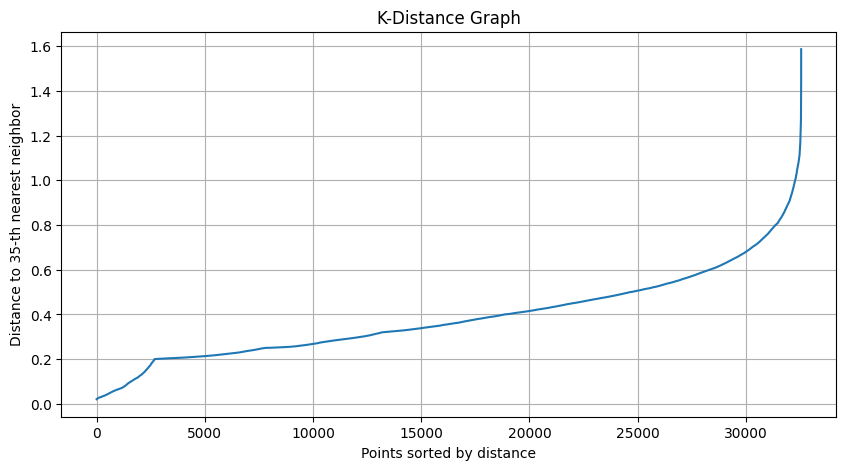

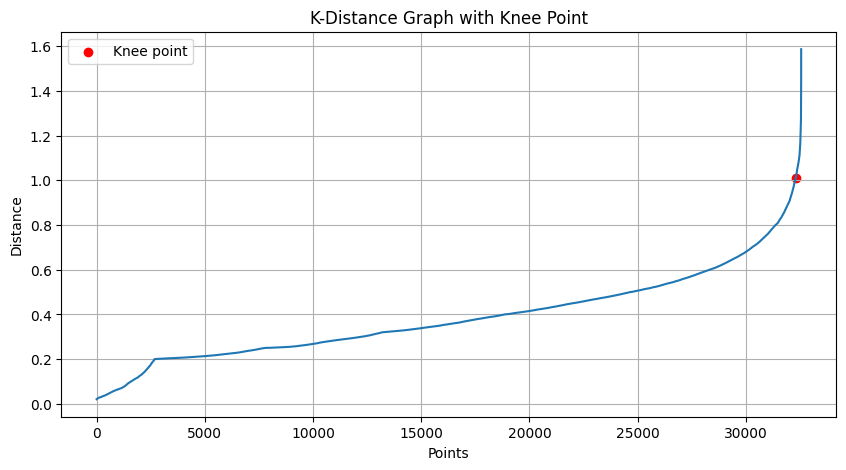

In [ ]:
sorted_distances = k_distance_curve(data)
initial_epsilon = find_knee_point(sorted_distances)

eps_values = np.linspace(initial_epsilon * 0.5, initial_epsilon * 1.5, 10)
k = 2 * data.shape[1] - 1

min_pts_range = range(int(k/2), k*2, 5)

In [ ]:
best_params, results = automated_dbscan(adult_distances, eps_values, min_pts_range)
print(best_params)

In [ ]:
def visualize_clusters(data, labels):
    """
    Use t-SNE to reduce dimensions for visualization of clusters.
    """
    tsne = TSNE(n_components=2, perplexity=30, n_iter=300)
    tsne_results = tsne.fit_transform(data)
    
    plt.figure(figsize=(10, 8))
    sns.scatterplot(x=tsne_results[:, 0], y=tsne_results[:, 1], hue=labels, palette='viridis', legend='full')
    plt.title('t-SNE Visualization of Clusters')
    plt.xlabel('TSNE Component 1')
    plt.ylabel('TSNE Component 2')
    plt.legend(title='Cluster')
    plt.show()

In [ ]:
def dbscan_clustering(data, eps, min_samples):
    """
    Apply DBSCAN clustering using optimized parameters and return labels.
    """
    db = DBSCAN(eps=eps, min_samples=min_samples)
    labels = db.fit_predict(data)
    return labels

#clusters = dbscan_clustering(data, 0.922776948448327, 17)

In [ ]:
visualize_clusters(data, clusters)

# Australia Credit

In [29]:
diabetic_df = pd.read_csv('diabetic_data.csv')

diabetic_df = diabetic_df[:1000]

In [30]:
# Replace 'delimiter_here' with the actual delimiter used in your .dat file (e.g., ',', '\t', '|', etc.)
# Assuming adult_df is already loaded as a pandas DataFrame
diabetic_data, label_encoders = preprocess_data(diabetic_df)
entropy_values = calculate_entropy(diabetic_data)

diabetic_distances = get_distance_matrix(diabetic_data, entropy_values)

/var/folders/j0/85cyxkys2bs8n9q_b_twkb700000gn/T/ipykernel_30513/864845061.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  numerical_indices = [i for i in indices if data.dtypes[i] == 'float64']  # Adjusted for scaled numerical data
/var/folders/j0/85cyxkys2bs8n9q_b_twkb700000gn/T/ipykernel_30513/864845061.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  numerical_indices = [i for i in indices if data.dtypes[i] == 'float64']  # Adjusted for scaled numerical data
/var/folders/j0/85cyxkys2bs8n9q_b_twkb700000gn/T/ipykernel_30513/864845061.py:3: FutureWarning: Series.__getitem__ treating keys as positions is depre

[[0.         2.81640869 2.58344612 ... 2.92035109 2.96606195 2.88862807]
 [2.81640869 0.         2.03461798 ... 1.78537555 1.98439176 2.36430936]
 [2.58344612 2.03461798 0.         ... 2.53081816 2.22977617 2.45029584]
 ...
 [2.92035109 1.78537555 2.53081816 ... 0.         1.54376623 1.51873897]
 [2.96606195 1.98439176 2.22977617 ... 1.54376623 0.         1.52612749]
 [2.88862807 2.36430936 2.45029584 ... 1.51873897 1.52612749 0.        ]]


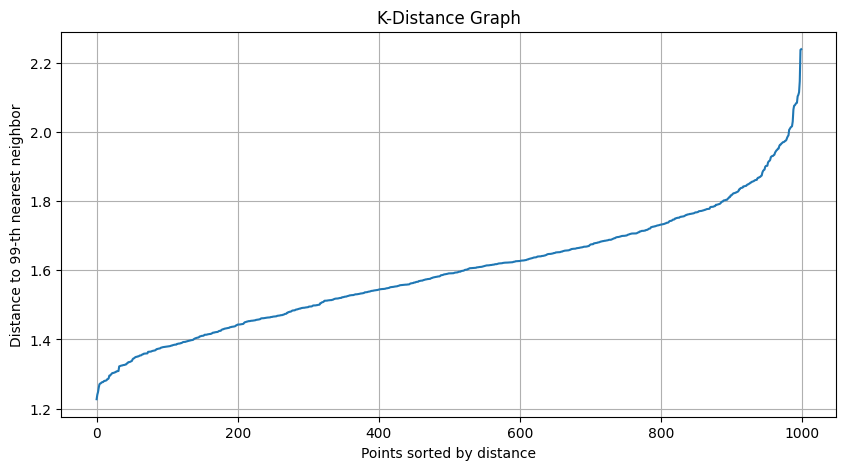

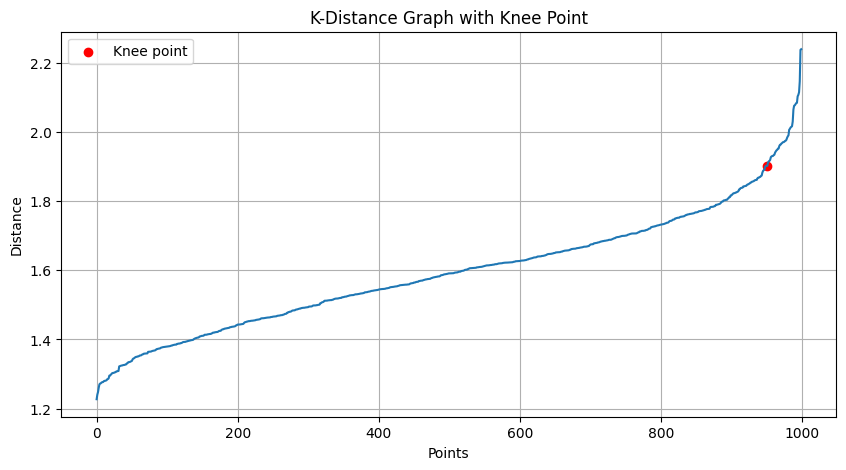

In [32]:
sorted_distances = k_distance_curve(diabetic_data)
initial_epsilon = find_knee_point(sorted_distances)

eps_values = np.linspace(initial_epsilon * 0.5, initial_epsilon * 1.5, 10)
k = 2 * diabetic_data.shape[1] - 1

min_pts_range = range(2, k*2, 5)

In [33]:
best_params, results = automated_dbscan(diabetic_distances, eps_values, min_pts_range)
print(best_params)

eps: 0.951358855967879, minPts: 2, clusters: 45
Eps: 0.951358855967879, MinPts: 2, Silhouette: -0.0048333802582178256
eps: 0.951358855967879, minPts: 7, clusters: 14
Eps: 0.951358855967879, MinPts: 7, Silhouette: -0.05129221117046704
eps: 0.951358855967879, minPts: 12, clusters: 8
Eps: 0.951358855967879, MinPts: 12, Silhouette: -0.06822330378957359
eps: 0.951358855967879, minPts: 17, clusters: 5
Eps: 0.951358855967879, MinPts: 17, Silhouette: -0.03347706350971926
eps: 0.951358855967879, minPts: 22, clusters: 4
Eps: 0.951358855967879, MinPts: 22, Silhouette: -0.06100540809774126
eps: 0.951358855967879, minPts: 27, clusters: 4
Eps: 0.951358855967879, MinPts: 27, Silhouette: -0.0909892298393096
eps: 0.951358855967879, minPts: 32, clusters: 2
eps: 0.951358855967879, minPts: 37, clusters: 1
eps: 0.951358855967879, minPts: 42, clusters: 1
eps: 0.951358855967879, minPts: 47, clusters: 1
eps: 0.951358855967879, minPts: 52, clusters: 1
eps: 0.951358855967879, minPts: 57, clusters: 1
eps: 0.9513

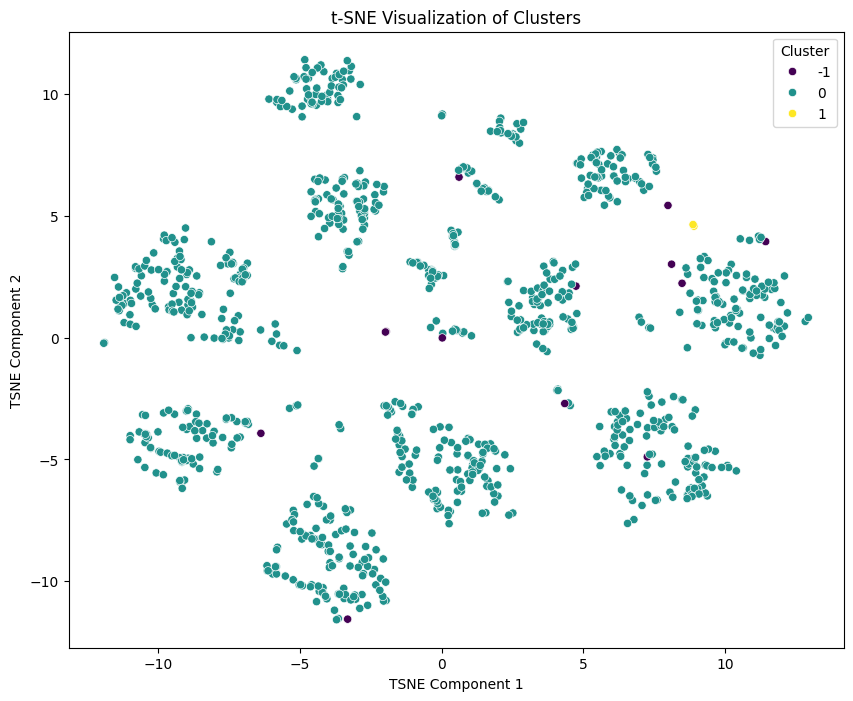

In [34]:
clusters = dbscan_clustering(diabetic_data, 1.3741850141758252, 2)
visualize_clusters(diabetic_data, clusters)